## Evaluator Pattern

##### Set up a Database

In [ ]:
import sqlite3

# Initialize SQLite connection to Chinook database
def get_db_connection():
    conn = sqlite3.connect("../data/chinook.db")
    conn.row_factory = sqlite3.Row
    return conn


# Function to get database schema info
def get_db_schema():
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Get all tables
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    
    schema_info = []
    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        
        cols = [f"{col['name']} ({col['type']})" for col in columns]
        schema_info.append(f"Table: {table_name}\nColumns: {', '.join(cols)}")
    
    # Get some sample data and foreign keys for better understanding
    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA foreign_key_list({table_name});")
        foreign_keys = cursor.fetchall()
        if foreign_keys:
            fk_info = [f"Foreign Key: {fk['from']} references {fk['table']}.{fk['to']}" for fk in foreign_keys]
            schema_info.append(f"Foreign Keys for {table_name}:\n" + "\n".join(fk_info))
    
    conn.close()
    return "\n".join(schema_info)

##### Get the Environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [ ]:
## Model - Agent Brain
from langchain_aws import ChatBedrock
llm = ChatBedrock(model=model_id)

##### State - The schema of the State will be the input schema to all Nodes and Edges in the graph

In [39]:
# Graph state
from typing import TypedDict
from typing import Dict, List

class State(TypedDict):
    question: str
    sql_query: str
    feedback: str
    optimized: str
    results: List[Dict]

##### Tools - Query Generator, Query Evaluator, Query Executor

In [40]:
from textwrap import dedent

# Nodes
def query_generator(state: State):
    print("QUERY GENERATOR")

    original_query = ''
    feedback = ''
    if "sql_query" in state:
        original_query = state["sql_query"]
        feedback = state["feedback"]

    sql_creator_system_message = dedent(f"""
        You are an expert SQL query optimizer who creates accurate, efficient SQL queries from natural language questions.
        
        DATABASE SCHEMA:
        {get_db_schema()}
        
        Your goal is to create SQL correctly to answers the question:  {state['question']}
        Consider:
        - Previous generated query for optimiztion in {original_query}
        - feedback on the previous query generation in {feedback}
        
        Return only the SQL query.
        Do not include any other text in your response.

  
    """)


    msg = llm.invoke(sql_creator_system_message)
    return {"sql_query": msg.content}

In [41]:
# Schema for structured output to use in evaluation
from pydantic import BaseModel, Field
from typing import Literal

class Feedback(BaseModel):
    grade: Literal[True, False] = Field(
        description="Decide if the sql query is optimized or now",
    )
    feedback: str = Field(
        description="if the sql query is not optimized, provide feedback on how to improve it.",
    )
    
def query_evaluator(state: State):
    print("QUERY_EVALUATOR")
    # Pass the question and SQL query to the verification agent
    verification_prompt = f"""
    User question: {state['question']}
    SQL query to verify:
    
    {state['sql_query']}
    
    Analyze this SQL query for correctness, efficiency, and whether it properly answers the question.
    """

    # Augment the LLM with schema for structured output
    evaluator = llm.with_structured_output(Feedback)
    result = evaluator.invoke(verification_prompt)
    print(state["sql_query"])
    return {"optimized": result.grade, "feedback": result.feedback}


In [42]:
# Execute SQL to get result
def sql_executor(state:State):
    print("EXECUTE QUERY")
    try:
        conn = get_db_connection()
        cursor = conn.cursor()
        cursor.execute(state['sql_query'])
        rows = cursor.fetchall()
        results = [dict(row) for row in rows]
        conn.close()
        return {"results": results}
    except Exception as e:
        return [{"error": str(e)}]

##### Router

In [43]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_path(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["optimized"] == True:
        return "Accepted"
    elif state["foptimized"] == False:
        return "Rejected + Feedback"

##### Graph

In [44]:
# Build workflow
from langgraph.graph import StateGraph, START, END

optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("generate_query", query_generator)
optimizer_builder.add_node("evaluate_query", query_evaluator)
optimizer_builder.add_node("execute_sql", sql_executor)


# Add edges to connect nodes
optimizer_builder.add_edge(START, "generate_query")
optimizer_builder.add_edge("generate_query", "evaluate_query")
optimizer_builder.add_conditional_edges(
    "evaluate_query",
    route_path,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": "execute_sql",
        "Rejected + Feedback": "generate_query",
    },
)
optimizer_builder.add_edge("execute_sql", END)

##### Compile the Graph

In [ ]:
# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

##### Display the graph

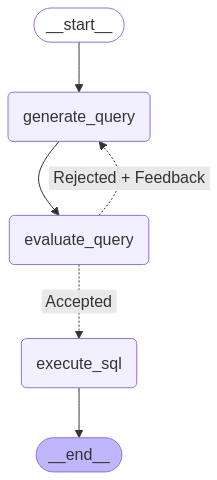

In [ ]:
# Show the workflow
from IPython.display import Image, display
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

##### Invoke Agent

In [46]:
# Invoke
state = optimizer_workflow.invoke({"question": "How many songs are in each genre"})
print(state["sql_query"])
print(state['results'])

QUERY GENERATOR
QUERY_EVALUATOR
SELECT g.Name as Genre, COUNT(t.TrackId) as NumberOfSongs
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY g.Name;
EXECUTE QUERY
SELECT g.Name as Genre, COUNT(t.TrackId) as NumberOfSongs
FROM genres g
LEFT JOIN tracks t ON g.GenreId = t.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY g.Name;
[{'Genre': 'Alternative', 'NumberOfSongs': 40}, {'Genre': 'Alternative & Punk', 'NumberOfSongs': 332}, {'Genre': 'Blues', 'NumberOfSongs': 81}, {'Genre': 'Bossa Nova', 'NumberOfSongs': 15}, {'Genre': 'Classical', 'NumberOfSongs': 74}, {'Genre': 'Comedy', 'NumberOfSongs': 17}, {'Genre': 'Drama', 'NumberOfSongs': 64}, {'Genre': 'Easy Listening', 'NumberOfSongs': 24}, {'Genre': 'Electronica/Dance', 'NumberOfSongs': 30}, {'Genre': 'Heavy Metal', 'NumberOfSongs': 28}, {'Genre': 'Hip Hop/Rap', 'NumberOfSongs': 35}, {'Genre': 'Jazz', 'NumberOfSongs': 130}, {'Genre': 'Latin', 'NumberOfSongs': 579}, {'Genre': 'Metal', 'NumberOfSongs': 

#### Testing

In [ ]:
from textwrap import dedent

# Nodes
def query_generator(state: State):
    print("QUERY GENERATOR")

    original_query = ''
    feedback = ''
    if "sql_query" in state:
        original_query = state["sql_query"]
        feedback = state["feedback"]

    sql_creator_system_message = dedent(f"""
        You are an expert SQL query optimizer who creates accurate, efficient SQL queries from natural language questions.
        
        DATABASE SCHEMA:
        {get_db_schema()}
        
        Your goal is to create SQL correctly to answers the question:  {state['question']}
        Consider:
        - Previous generated query for optimiztion in {original_query}
        - feedback on the previous query generation in {feedback}
        
        Return only the SQL query.
        Do not include any other text in your response.

  
    """)


    msg = llm.invoke(sql_creator_system_message)
    return msg.content

In [ ]:
teststate = State()
teststate['question'] = 'How many songs are in each genre'

query_generator(teststate)


In [ ]:
# Schema for structured output to use in evaluation
from pydantic import BaseModel, Field
from typing import Literal

class Feedback(BaseModel):
    grade: Literal[True, False] = Field(
        description="Decide if the sql query is optimized or now",
    )
    feedback: str = Field(
        description="if the sql query is not optimized, provide feedback on how to improve it.",
    )
    
def query_evaluator(sql_query, question):
    print("QUERY_EVALUATOR")
    # Pass the question and SQL query to the verification agent
    verification_prompt = f"""
    User question: {question}
    SQL query to verify:
    
    {sql_query}
    
    Analyze this SQL query for correctness, efficiency, and whether it properly answers the question.
    """

    # Augment the LLM with schema for structured output
    evaluator = llm.with_structured_output(Feedback)
    result = evaluator.invoke(verification_prompt)
    return result


In [ ]:
question = 'How many songs are in each genre'
query = "'SELECT g.Name as Genre, COUNT(t.TrackId) as SongCount\nFROM Genre g\nLEFT JOIN Track t ON g.GenreId = t.GenreId\nGROUP BY g.GenreId, g.Name\nORDER BY SongCount DESC;'"

In [ ]:
result = query_evaluator(query, question)
result.grade    